# Визуализация
Визуализируем результаты работы контроллера: загрузка последних запусков, расчёт метрик (ISE/IAE, перерегулирование, время установления) сравнение запусков.
## TODO
Подумать над метриками

In [142]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

try:
    import matplotlib.pyplot as plt
    from matplotlib import gridspec, animation
except ImportError as e:
    raise ImportError("matplotlib is required for this notebook") from e

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    warnings.warn("seaborn not installed; proceeding without it")

try:
    import plotly.express as px
except ImportError:
    px = None
    warnings.warn("plotly not installed; interactive plotly charts will be skipped")

try:
    import ipywidgets as widgets
    from IPython.display import display, HTML
except ImportError:
    widgets = None
    HTML = lambda x: x
    warnings.warn("ipywidgets not installed; interactive widgets will be skipped")

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.grid": True,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
})

C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\3994569861.py:31: UserWarning: ipywidgets not installed; interactive widgets will be skipped
  warnings.warn("ipywidgets not installed; interactive widgets will be skipped")


## Загрузка данных
Определяем последний запуск, загружаем таблицы `model_state`, `control_actions`, `Controller_PID` и объединяем их в одну временную шкалу.

In [143]:
RESULTS_ROOT = Path("../results")
RUN_PATTERN = "Simulation"  # broader to поймать PID и ARX

def list_runs(root: Path = RESULTS_ROOT, pattern: str = RUN_PATTERN) -> list[Path]:
    runs = [p for p in root.glob(f"*{pattern}*") if p.is_dir()]
    if not runs:
        # fallback: все папки внутри results
        runs = [p for p in root.iterdir() if p.is_dir()]
    return sorted(runs, key=lambda p: p.stat().st_mtime, reverse=True)


def load_run(run_path: Path) -> dict[str, pd.DataFrame]:
    files = {
        "model_state": run_path / "model_state.csv",
        "control_actions": run_path / "control_actions.csv",
    }

    controller_candidates = sorted(run_path.glob("Controller_*.csv"))
    if controller_candidates:
        files["controller"] = controller_candidates[0]
    else:
        legacy_pid = run_path / "Controller_PID.csv"
        if legacy_pid.exists():
            files["controller"] = legacy_pid

    estimator_candidates = sorted(run_path.glob("*Estimator*.csv"))
    if estimator_candidates:
        files["estimator"] = estimator_candidates[0]
    else:
        legacy_est = run_path / "PIDEstimator.csv"
        if legacy_est.exists():
            files["estimator"] = legacy_est

    data = {}
    for name, fp in files.items():
        if fp.exists():
            data[name] = pd.read_csv(fp)
        else:
            warnings.warn(f"{fp} not found; skipping {name}")
    return data


def _find_y_column(base: pd.DataFrame) -> str | None:
    alias_keys = {"y", "level", "output", "value", "position"}
    for col in base.columns:
        norm = col.strip().lower().replace(" ", "")
        if norm in alias_keys:
            return col
    numeric_candidates = [c for c in base.columns if c.lower() != "time" and pd.api.types.is_numeric_dtype(base[c])]
    return numeric_candidates[0] if numeric_candidates else None


def _ensure_y(base: pd.DataFrame) -> pd.DataFrame:
    if "y" in base.columns:
        return base
    candidates = [c for c in base.columns if c.startswith("y") and pd.api.types.is_numeric_dtype(base[c])]
    if candidates:
        chosen = candidates[0]
        warnings.warn(f"y не найден, используем {chosen} как y")
        base = base.rename(columns={chosen: "y"})
        return base
    numeric_candidates = [c for c in base.columns if c.lower() != "time" and pd.api.types.is_numeric_dtype(base[c])]
    if numeric_candidates:
        chosen = numeric_candidates[0]
        warnings.warn(f"y не найден, берём {chosen} как y")
        base = base.rename(columns={chosen: "y"})
        return base
    raise KeyError(f"Не удалось найти столбец выхода y. Колонки после merge: {list(base.columns)}")


def merge_run(data: dict[str, pd.DataFrame]) -> pd.DataFrame:
    if not data:
        raise ValueError("No data to merge")
    base = data["model_state"].copy()
    base = base.rename(columns={"disturbance": "w"})

    y_col = _find_y_column(base)
    if y_col and y_col != "y":
        base = base.rename(columns={y_col: "y"})
    else:
        base = _ensure_y(base)

    if "control_actions" in data:
        base = base.merge(data["control_actions"], on="time", how="left", suffixes=("", "_ctrl"))
    if "controller" in data:
        ctrl = data["controller"].copy()
        ctrl = ctrl.rename(columns={"u": "u_ctrl"})
        base = base.merge(ctrl, on="time", how="left")
    base = _ensure_y(base)

    if "setpoint" not in base.columns and "controller" in data and "setpoint" in data["controller"].columns:
        base = base.merge(data["controller"]["setpoint"].to_frame().assign(time=data["controller"]["time"]), on="time", how="left", suffixes=("", "_sp"))
    base["setpoint"] = base.get("setpoint", pd.Series(index=base.index, data=np.nan)).ffill()

    base["error"] = base["setpoint"] - base["y"]
    return base


runs = list_runs()
if not runs:
    raise FileNotFoundError(f"Нет результатов в папке {RESULTS_ROOT}")

current_run = runs[0]
raw_data = load_run(current_run)
df = merge_run(raw_data)
current_run

C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\1188260039.py:59: UserWarning: y не найден, используем y_x как y
  warnings.warn(f"y не найден, используем {chosen} как y")


WindowsPath('../results/2025-12-18_03-21-23 Simulation for ARX Tank Simulation RST')

## Предобработка и метрики
Считаем ошибку, ISE/IAE, перерегулирование и время установления по последнему значению уставки.

In [144]:
def compute_metrics(df: pd.DataFrame, settle_tol: float = 0.02) -> dict[str, float]:
    t = df["time"].to_numpy()
    e = df["error"].to_numpy()
    dt = np.diff(t, prepend=t[0])

    ise = float(np.trapz(e ** 2, t))
    iae = float(np.trapz(np.abs(e), t))

    setpoint_final = float(df["setpoint"].iloc[-1]) if not df["setpoint"].isna().all() else np.nan
    overshoot = np.nan
    if setpoint_final and setpoint_final != 0:
        overshoot = float((df["y"].max() - setpoint_final) / setpoint_final * 100)

    settling_time = np.nan
    if not np.isnan(setpoint_final):
        band = settle_tol * abs(setpoint_final)
        within_band = np.abs(e) <= band
        for i in range(len(df) - 1, -1, -1):
            if not within_band[i]:
                break
            settling_time = float(df["time"].iloc[i])
        if settling_time is None:
            settling_time = float(df["time"].iloc[-1])

    return {
        "ISE": ise,
        "IAE": iae,
        "Overshoot_%": overshoot,
        "SettlingTime": settling_time,
    }

metrics = compute_metrics(df)
metrics

C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\2192175510.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ise = float(np.trapz(e ** 2, t))
C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\2192175510.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  iae = float(np.trapz(np.abs(e), t))


{'ISE': 1954.6713733389827,
 'IAE': 426.6171821573991,
 'Overshoot_%': 3.5084289080792974,
 'SettlingTime': 375.0}

## Статические графики
Отклик системы, ошибка, скорость и управляющее воздействие. Сохраняем итоговый рисунок в `summary.png` выбранного запуска.

Saved ..\results\2025-12-18_03-21-23 Simulation for ARX Tank Simulation RST\summary.png


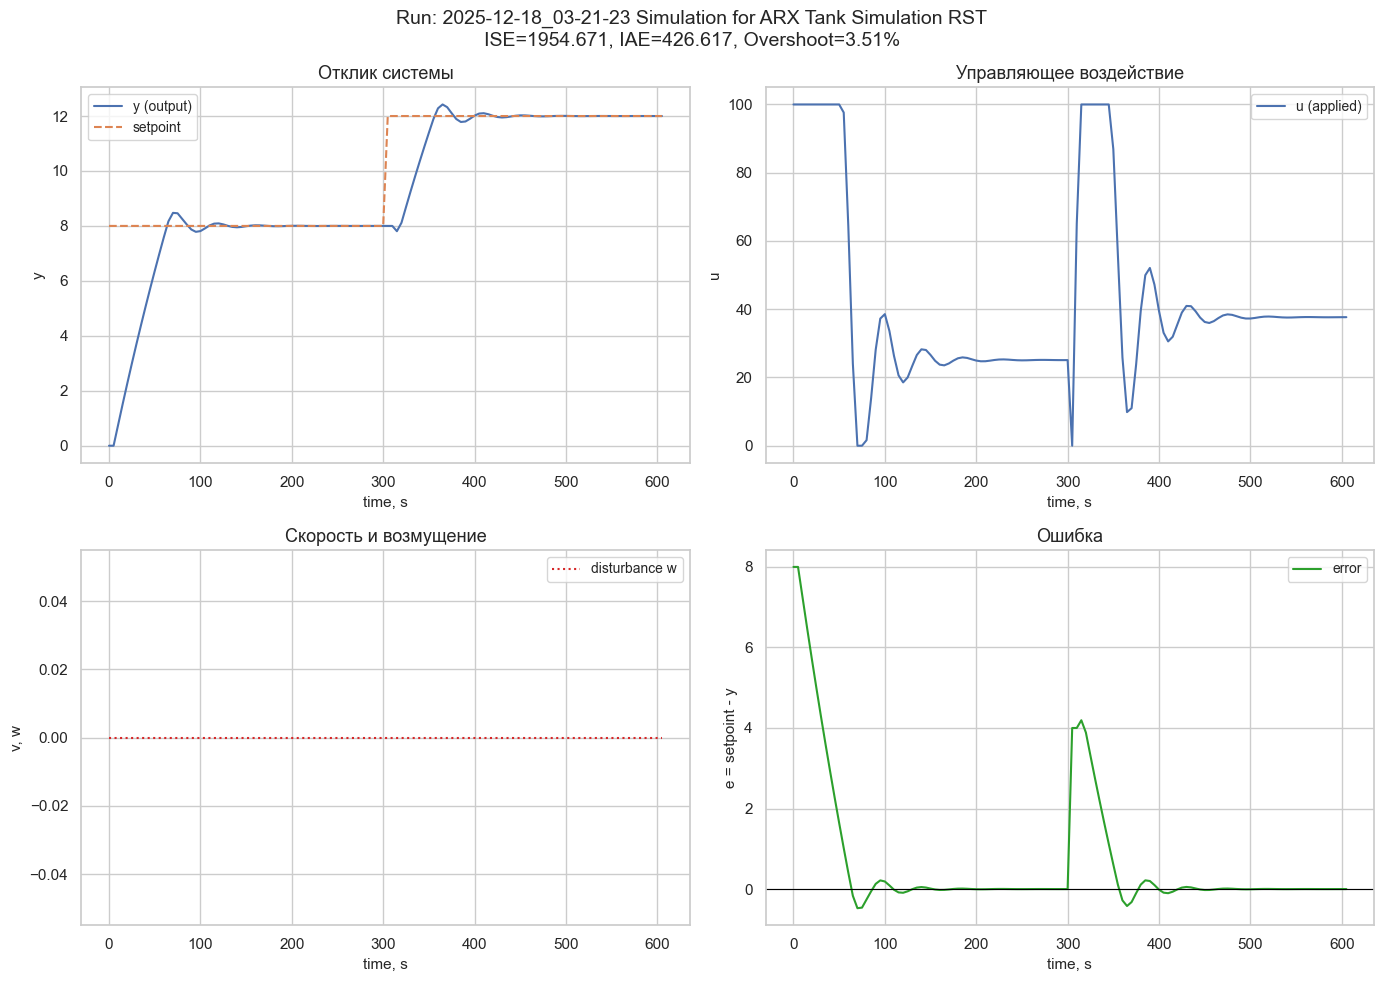

In [145]:
def plot_static(df: pd.DataFrame, run_path: Path, save: bool = True):
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(df["time"], df["y"], label="y (output)")
    ax1.plot(df["time"], df["setpoint"], label="setpoint", linestyle="--")
    ax1.set_title("Отклик системы")
    ax1.set_xlabel("time, s")
    ax1.set_ylabel("y")
    ax1.legend()

    ax2 = fig.add_subplot(gs[0, 1])
    if "u" in df.columns:
        ax2.plot(df["time"], df["u"], label="u (applied)")
    if "u_ctrl" in df.columns:
        ax2.plot(df["time"], df["u_ctrl"], label="u (controller)", alpha=0.6)
    ax2.set_title("Управляющее воздействие")
    ax2.set_xlabel("time, s")
    ax2.set_ylabel("u")
    ax2.legend()

    ax3 = fig.add_subplot(gs[1, 0])
    if "v" in df.columns:
        ax3.plot(df["time"], df["v"], label="velocity v", color="tab:orange")
    if "w" in df.columns:
        ax3.plot(df["time"], df["w"], label="disturbance w", color="tab:red", linestyle=":")
    ax3.set_title("Скорость и возмущение")
    ax3.set_xlabel("time, s")
    ax3.set_ylabel("v, w")
    ax3.legend()

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(df["time"], df["error"], label="error", color="tab:green")
    ax4.axhline(0, color="black", linewidth=0.8)
    ax4.set_title("Ошибка")
    ax4.set_xlabel("time, s")
    ax4.set_ylabel("e = setpoint - y")
    ax4.legend()

    fig.suptitle(f"Run: {run_path.name}\nISE={metrics['ISE']:.3f}, IAE={metrics['IAE']:.3f}, Overshoot={metrics['Overshoot_%']:.2f}%", fontsize=14)
    fig.tight_layout()

    if save:
        out_path = run_path / "summary.png"
        fig.savefig(out_path, dpi=200)
        print(f"Saved {out_path}")
    return fig

_ = plot_static(df, current_run)
plt.show()

## Сравнение запусков
Собираем метрики по всем найденным запускам и строим сравнение.

C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\1188260039.py:59: UserWarning: y не найден, используем y_x как y
  warnings.warn(f"y не найден, используем {chosen} как y")
C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\2192175510.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ise = float(np.trapz(e ** 2, t))
C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\2192175510.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  iae = float(np.trapz(np.abs(e), t))
C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\1188260039.py:59: UserWarning: y не найден, используем y_x как y
  warnings.warn(f"y не найден, используем {chosen} как y")
C:\Users\ilj4g\AppData\Local\Temp\ipykernel_14280\2192175510.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration fu

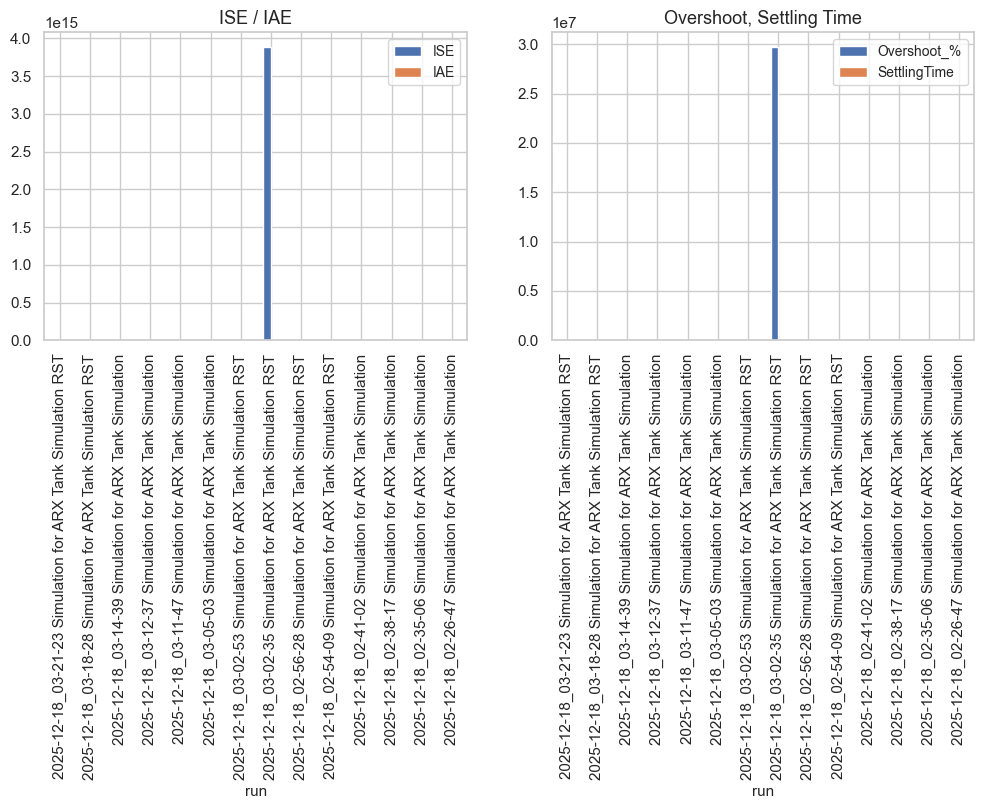

In [146]:
def collect_metrics(runs: list[Path]) -> pd.DataFrame:
    rows = []
    for run in runs:
        data = load_run(run)
        if "model_state" not in data:
            continue
        df_local = merge_run(data)
        m = compute_metrics(df_local)
        m["run"] = run.name
        rows.append(m)
    return pd.DataFrame(rows)

metrics_df = collect_metrics(runs)
metrics_df

if not metrics_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    metrics_df.plot(x="run", y=["ISE", "IAE"], kind="bar", ax=axes[0])
    axes[0].set_title("ISE / IAE")
    metrics_df.plot(x="run", y=["Overshoot_%", "SettlingTime"], kind="bar", ax=axes[1])
    axes[1].set_title("Overshoot, Settling Time")
    plt.tight_layout()
    plt.show()
else:
    print("No metrics to display")

## TODO
Починить первый график

## Оценка качества регулятора
Рассчитываем метрики (ISE, IAE, перерегулирование, время установления), итоговые значения уровня/скорости/управления и выводим компактный отчёт.

In [147]:
def summarize_run(df: pd.DataFrame, metrics: dict) -> pd.DataFrame:
    last = df.iloc[-1]
    summary = {
        "ISE": metrics.get("ISE"),
        "IAE": metrics.get("IAE"),
        "Overshoot_%": metrics.get("Overshoot_%"),
        "SettlingTime": metrics.get("SettlingTime"),
        "y_final": last.get("y", np.nan),
        "v_final": last.get("v", np.nan),
        "u_final": last.get("u", np.nan),
        "setpoint_final": last.get("setpoint", np.nan),
    }
    return pd.DataFrame([summary])

summary_df = summarize_run(df, metrics)
display(summary_df)


,ISE,IAE,Overshoot_%,SettlingTime,y_final,v_final,u_final,setpoint_final
0,1954.671373,426.617182,3.508429,375.0,11.999828,NaN,37.670126,12.0
